### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import random


from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import cluster

warnings.filterwarnings("ignore")

#### Importing previously generated dataset via spotify API and concatenating with an existing dataset

In [2]:
data = pd.read_csv('Data/spotify_df.csv')

# Loading auxiliary dataset 
aux_data = pd.read_csv('Data/SpotifyAudioFeaturesApril2019.csv')
aux_data.rename(columns={'artist_name': 'artist'}, inplace=True)
aux_data = aux_data[data.columns]

In [3]:
# Concatenating datasets into one big final dataset
data = pd.concat([data, aux_data], axis = 0)
# Saving full dataset to csv for further usage
data.to_csv('Data/Full_List.csv',index=False)

### Creating the clusters

In [4]:
# Selecting the rows to model
X = data.drop(columns = ['track_id', 'artist', 'track_name'])

In [5]:
# Function to pickle the scaler used for further usage
def export_scaler(scaler):
    import pickle
    filename = 'Model_data/scaler.sav'
    pickle.dump(scaler, open(filename, 'wb'))

In [6]:
# Scaling and pickling the dataset
scaler = StandardScaler().fit(X)
X_train = pd.DataFrame(scaler.transform(X), columns = X.columns)
export_scaler(scaler)
X_train.head(4)

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-0.345713,0.587435,0.211534,0.677978,-1.243422,-0.444162,-0.602845,0.707805,0.850125,1.780318,-0.385653,0.227316
1,0.638555,0.842888,-1.453397,0.586136,0.804232,-0.511574,-0.603591,-0.839745,1.481751,0.659103,-0.543247,0.227316
2,0.542268,-0.329872,-1.175909,0.404323,0.804232,-0.610225,-0.605524,1.257052,0.997375,1.615651,0.156750,0.227316
3,1.344661,0.633881,1.321488,0.527195,-1.243422,-0.362775,-0.605688,0.852661,1.082625,-0.366034,-0.180305,0.227316


#### Function to plot and choose the best node size

In [ ]:
K = range(2, 10)
inertia = []
silhouette = []

for k in K:
    print(k)
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_train, kmeans.predict(X_train)))

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

plt.show()

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette score showing the optimal k')

Inertia Score
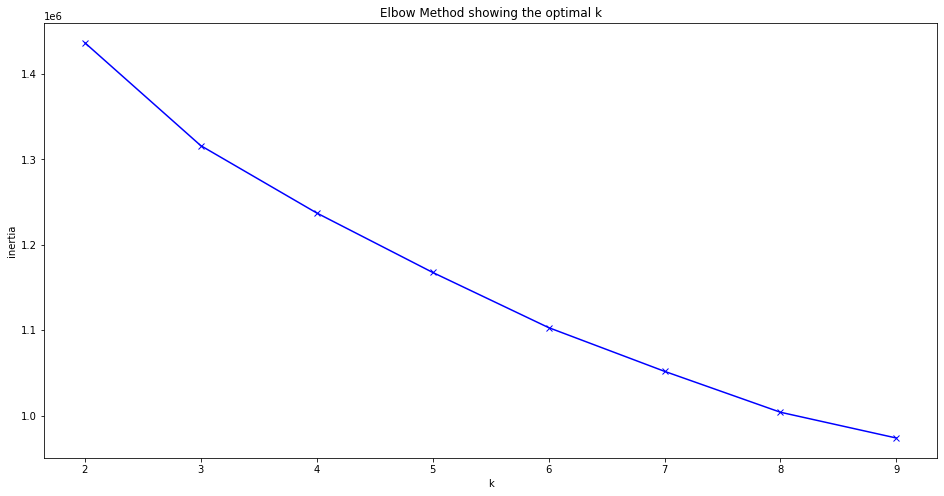

Silhouette Score
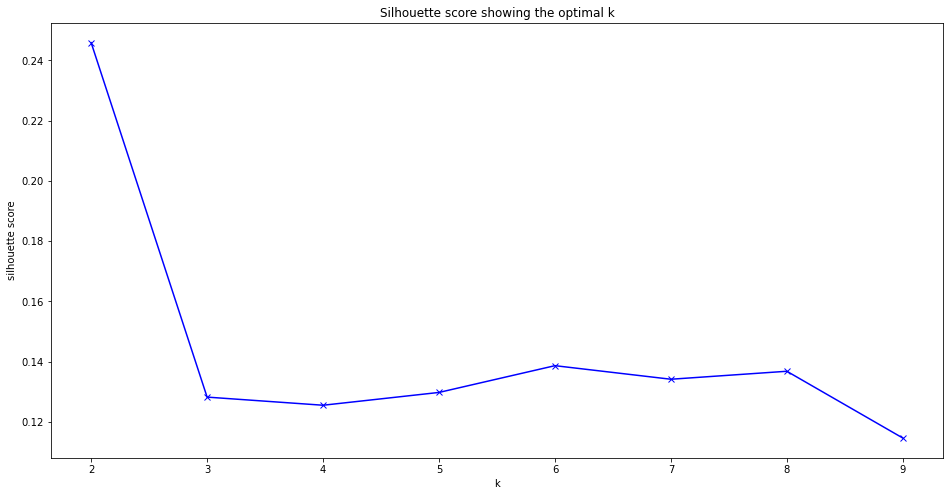

### Choosing clustering mode

In [8]:
# Function that builds and evaluates every model that is provided
def eval_model(model, nodes):
    print('Training', type(model).__name__)
    clusters = model.fit_predict(X_train)
    print('\n',type(model).__name__,'with nodes',nodes,'Silhouette score: ', round(silhouette_score(X_train, clusters), 2))
    print(pd.Series(clusters).value_counts().sort_index())
    return None

In [9]:
from sklearn.cluster import BisectingKMeans

# Creating a list of models to be evaluated
node = 8
models = [KMeans(n_clusters=node), 
          cluster.KMeans(n_clusters=node),
          BisectingKMeans(n_clusters=node)]

# Loop that goes through all models, builds and evaluates them.
# for model in models:
#     eval_model(model, node)

#### Listening to songs and try to check validity

In [10]:
# Building the final model and makin predictions
model = models[1].fit(X_train)
clusters = model.predict(X_train)

In [12]:
# Adding a column with clusters ID
data['cluster'] = clusters

#### Saving clustered dataset to csv

In [13]:
data.to_csv('Data/Final/Spotify dataset clustered.csv', index = False)
data.head(5)

,track_id,artist,track_name,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,4LRPiXqCikLlN15c3yImP7,Harry Styles,As It Was,0.520,0.731,6,-5.338,0,0.0557,0.001010,0.3110,0.662,173.930,167303,4,6
1,4h9wh7iOZ0GGn8QVp4RAOB,OneRepublic,I Ain't Worried,0.704,0.797,0,-5.927,1,0.0475,0.000745,0.0546,0.825,139.994,148486,4,2
2,4k6Uh1HXdhtusDW5y8Gbvy,Steve Lacy,Bad Habit,0.686,0.494,1,-7.093,1,0.0355,0.000058,0.4020,0.700,168.946,232067,4,2
3,1PckUlxKqWQs3RlWXVBLw3,Lizzo,About Damn Time,0.836,0.743,10,-6.305,0,0.0656,0.000000,0.3350,0.722,108.966,191822,4,6
4,3nqQXoyQOWXiESFLlDF1hG,Sam Smith,Unholy (feat. Kim Petras),0.714,0.472,2,-7.375,1,0.0864,0.000005,0.2660,0.238,131.121,156943,4,3


#### Link generation for music listening of the clusters

In [ ]:
for i in pd.unique(data['cluster']):
    subset = list(data['track_id'][data['cluster'] == i])
    print('GROUP', i)
    for j in range(5):
        print('https://open.spotify.com/track/'+subset[random.randint(0,len(subset))])

##### Pickle model

In [15]:
def export_model(model):
    import pickle
    filename = 'Model_data/model_clustering.sav'
    pickle.dump(model, open(filename, 'wb'))

In [16]:
# Saving the model for further usage
export_model(model)